In [36]:
import sqlite3
import pandas as pd

ROWS_TO_READ = 500000

sql = sqlite3.connect('test.db')
df = pd.read_sql_query(f'SELECT * FROM evaluations LIMIT {ROWS_TO_READ}', sql)

df.head(10)

,id,fen,binary,eval
0,1,rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR ...,b'\x08\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00...,0.00
1,2,rnbqkbnr/ppp1pppp/8/3p4/3P4/8/PPP1PPPP/RNBQKBN...,b'\x08\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00...,0.27
2,3,rnbqkbnr/ppp1pppp/8/3p4/2PP4/8/PP2PPPP/RNBQKBN...,b'\x08\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00...,0.00
3,4,rnbqkbnr/ppp2ppp/4p3/3p4/2PP4/8/PP2PPPP/RNBQKB...,b'\x08\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00...,0.09
4,5,rnbqkbnr/ppp2ppp/4p3/3P4/3P4/8/PP2PPPP/RNBQKBN...,b'\x08\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00...,0.10
5,6,rnbqkbnr/ppp2ppp/8/3p4/3P4/8/PP2PPPP/RNBQKBNR ...,b'\x08\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00...,0.00
6,7,rnbqkbnr/ppp2ppp/8/3p4/3P4/2N5/PP2PPPP/R1BQKBN...,b'\x08\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00...,0.09
7,8,rnbqkb1r/ppp2ppp/5n2/3p4/3P4/2N5/PP2PPPP/R1BQK...,b'\x08\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00...,0.13
8,9,rnbqkb1r/ppp2ppp/5n2/3p4/3P4/2N1P3/PP3PPP/R1BQ...,b'\x08\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00...,-0.22
9,10,rnbqk2r/ppp2ppp/3b1n2/3p4/3P4/2N1P3/PP3PPP/R1B...,b'\x08\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00...,-0.26


In [37]:
import numpy as np

def make_matrix(fen):
    res = [] 
    rows = fen.split('/')
    for row in rows:
        row_list = []
        pieces = row.split(" ", 1)[0]
        for thing in pieces:
            if thing.isdigit():
                row_list += '.' * int(thing)
            else:
                row_list += thing
        res.append(row_list)
    return res

def extract_metadata(fen):
    res = [] 
    data = fen.split(' ')
    
    if data[1][0] == 'w': res.append(1)
    else: res.append(0)

    if "K" in data[2]: res.append(1)
    else: res.append(0)

    if "Q" in data[2]: res.append(1)
    else: res.append(0)

    if "k" in data[2]: res.append(1)
    else: res.append(0)

    if "q" in data[2]: res.append(1)
    else: res.append(0)
        
    return res

table = {
    '.': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    
    'P': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'B': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'N': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'R': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    'Q': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    'K': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],

    'p': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    'b': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    'n': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    'r': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    'q': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    'k': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
}

def vectorize(fen, table):
    res = []
    for i in make_matrix(fen):
        res.append(list(map(table.get, i)))
    return np.array(res)

print(vectorize(df['fen'][0], table).shape) # should be 8 by 8 by 12

(8, 8, 12)


In [38]:
from tqdm.notebook import tqdm

vecs = []
meta = []
eval = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    vecs.append(vectorize(row['fen'], table))
    meta.append(extract_metadata(row['fen']))
    eval.append(row['eval'])

  0%|          | 0/500000 [00:00<?, ?it/s]

In [39]:
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split
import torch

X = torch.tensor(np.array(vecs), dtype=torch.float).permute(0, 3, 1, 2)
m = torch.tensor(np.array(meta), dtype=torch.float)
y = torch.tensor(np.array(eval), dtype=torch.float)

processed_dataset = TensorDataset(X, m, y)

# set proportion and split dataset into train and validation parts
proportion = 0.2
train_dataset, val_dataset = random_split(processed_dataset, [1-proportion, proportion])

In [40]:
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [41]:
def train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    val_loader,
    epochs=1,
    device="cpu",
    ckpt_path="best.pt",
):
    # best score for checkpointing
    best = 0
    
    # iterating over epochs
    for epoch in range(epochs):
        # training loop description
        train_loop = tqdm(
            enumerate(train_loader, 0), total=len(train_loader), desc=f"Epoch {epoch}"
        )
        model.to(device)
        model.train()
        train_loss = 0.0
        # iterate over dataset 
        for i, data in train_loop:
            inputs, meta, labels = data
            inputs, meta, labels = inputs.to(device), meta.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass and loss calculation
            outputs = model(inputs, meta)
            
            labels = torch.squeeze(labels)
            outputs = torch.squeeze(outputs)
            
            loss = loss_fn(outputs, labels)

            # backward pass
            loss.backward()

            # optimizer run
            optimizer.step()

            train_loss += loss.item()
            train_loop.set_postfix({"loss": train_loss/(i+1)})
        
        # validation
        errors = None
        
        with torch.no_grad():
            eval_loss = 0.0
            model.eval()  # evaluation mode
            val_loop = tqdm(enumerate(val_loader, 0), total=len(val_loader), desc="Val")
            for i, data in val_loop:
                inputs, meta, labels = data
                inputs, meta, labels = inputs.to(device), meta.to(device), labels.to(device)

                outputs = model(inputs, meta)
                labels = torch.squeeze(labels)
                outputs = torch.squeeze(outputs)
                
                loss = loss_fn(outputs, labels)

                eval_loss += loss.item()
                

            score = (i+1) / eval_loss
            print(f'eval_loss: {eval_loss / (i+1)}')

            if score > best:
                torch.save(model.state_dict(), ckpt_path)
                best = score
                
            scheduler.step(eval_loss / (i+1))


In [42]:
from torch import nn

class EvalConvMetaModel(nn.Module):

    def __init__(self):
        super(EvalConvMetaModel, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(12, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten(),
        )

        self.linear = nn.Sequential(
            nn.Linear(1024+5, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x, meta):
        x = self.conv(x)
        #print(x.shape, meta.shape)
        x = torch.cat((x, meta), 1)
        x = self.linear(x)
        return x


In [43]:
import torch.optim as optim

model = EvalConvMetaModel()
loss_fn = nn.L1Loss()
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [46]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.25)

train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=40
)

Epoch 0:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.524152473527558


Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.5458961153516966


Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.423437401348231


Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.396964513525671


Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.439911596020874


Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.483578250724442


Epoch 6:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.4269713230279026


Epoch 7:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.373588678179955


Epoch 8:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.4040628695974546


Epoch 9:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.3591878608781465


Epoch 10:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.3452985663803254


Epoch 11:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.4679021537303925


Epoch 12:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.344314445038231


Epoch 13:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.379202048389279


Epoch 14:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.309203774953375


Epoch 15:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.325915346340257


Epoch 16:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.329348999018572


Epoch 17:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.3543110167493624


Epoch 18:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.3158718718557942


Epoch 19:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.175746064405052


Epoch 20:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.1688764667024416


Epoch 21:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.1651561497425544


Epoch 22:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.1715565664427623


Epoch 23:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.162152364545939


Epoch 24:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.1992219351992315


Epoch 25:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.1739395668311996


Epoch 26:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.185080045948223


Epoch 27:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.2465943754935753


Epoch 28:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.152433474453128


Epoch 29:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.1502578866725064


Epoch 30:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.1514644336943722


Epoch 31:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.15711926075877


Epoch 32:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.1513849636729883


Epoch 33:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.1546739613523287


Epoch 34:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.151811390506978


Epoch 35:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.1608057314035842


Epoch 36:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.165771110933654


Epoch 37:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.1552325839899025


Epoch 38:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.16341725539188


Epoch 39:   0%|          | 0/782 [00:00<?, ?it/s]

Val:   0%|          | 0/196 [00:00<?, ?it/s]

eval_loss: 2.14835664447473


In [47]:
model = EvalConvMetaModel()
ckpt = torch.load("ConvMeta-2.1.pt")
model.load_state_dict(ckpt)

<All keys matched successfully>

In [51]:
import sqlite3
import pandas as pd

ROWS_TO_READ = 50

sql = sqlite3.connect('test.db')
df = pd.read_sql_query(f'SELECT * FROM evaluations LIMIT {ROWS_TO_READ}', sql)

df.tail(20)

,id,fen,binary,eval
30,31,r2q1rk1/ppp1b1pp/8/3n1p2/3P4/5N1R/PP3PPP/R1BQ2...,b'\x02\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00...,0.00
31,32,r2q1rk1/pp2b1pp/2p5/3n1p2/3P4/5N1R/PP3PPP/R1BQ...,b'\x02\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00...,-0.12
32,33,r2q1rk1/pp2b1pp/2p5/3nNp2/3P4/7R/PP3PPP/R1BQ2K...,b'\x02\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00...,-0.16
33,34,r2q1rk1/pp4pp/2p2b2/3nNp2/3P4/7R/PP3PPP/R1BQ2K...,b'\x02\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00...,0.31
34,35,r2q1rk1/pp4pp/2p2b2/3nNp1Q/3P4/7R/PP3PPP/R1B3K...,b'\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,0.40
35,36,r2q1rk1/pp4p1/2p2b1p/3nNp1Q/3P4/7R/PP3PPP/R1B3...,b'\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,0.21
36,37,r2q1rk1/pp4p1/2p2bNp/3n1p1Q/3P4/7R/PP3PPP/R1B3...,b'\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,-1.36
37,38,r3qrk1/pp4p1/2p2bNp/3n1p1Q/3P4/7R/PP3PPP/R1B3K...,b'\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,-0.06
38,39,r3qrk1/pp4p1/2p2bNB/3n1p1Q/3P4/7R/PP3PPP/R5K1 ...,b'\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,-1.76
39,40,r3qrk1/pp6/2p2bNp/3n1p1Q/3P4/7R/PP3PPP/R5K1 w ...,b'\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,-1.55


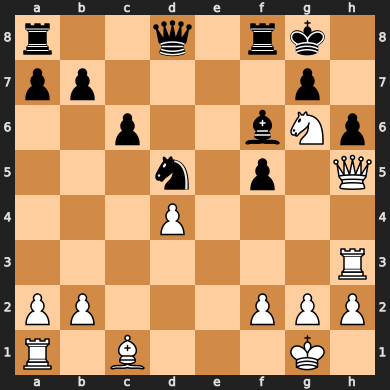

In [62]:
import chess

board = chess.Board(df['fen'][36])
board

In [63]:
import numpy as np

fen = df['fen'][36]

data = vectorize(fen, table)
data = torch.tensor(data, dtype=torch.float).permute(2, 0, 1).cpu()
data = data[None, :]

meta = extract_metadata(fen)
meta = torch.tensor(meta, dtype=torch.float).cpu()
meta = meta[None, :]

model = model.cpu()

with torch.no_grad():
    model.eval()
    res = model(data, meta).item()
print(res)

-2.59592866897583
